## Import general libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def show_correlation(df, size=(15,10)):
    corr = df.corr()
    fig, ax = plt.subplots()
    fig.set_size_inches(size[0], size[1])
    sns.heatmap(corr, annot=True, cmap='PiYG')

In [4]:
# test = pd.read_csv("../input/titanic/test.csv")
# train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [4]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Johnson, Mr. William Cahoone Jr",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Encode Sex and Cabin column and fill missing Ages with negative numbers

In [6]:
print('Train')
print(train.isnull().sum())
print('==========================')
print('Test')
print(test.isnull().sum())

Train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [7]:

train = train.fillna({'Age': -0.1})
test = test.fillna({'Age': -0.1})

#encode sex
sex_encoder = LabelEncoder()
sex_encoder.fit(['male', 'female'])
train['Sex'] = sex_encoder.transform(train['Sex'])
test['Sex'] = sex_encoder.transform(test['Sex'])


#encode cabin
train.loc[~train.Cabin.isnull(), 'Cabin'] = 1
train.loc[train.Cabin.isnull(), 'Cabin'] = 0

test.loc[~test.Cabin.isnull(), 'Cabin'] = 1
test.loc[test.Cabin.isnull(), 'Cabin'] = 0

#fill missed 'Embarked' values with max embarked places

#encode embarked feature
embarked_encoder = LabelEncoder()

#detect wich is a most common embarking place
common_embarked = train.groupby(['Embarked'])['Embarked'].value_counts().idxmax()[0]
train = train.fillna({'Embarked': common_embarked})
test = test.fillna({'Embarked': common_embarked})
embarked_encoder.fit(train['Embarked'].unique())
train['Embarked'] = embarked_encoder.transform(train['Embarked'])
test['Embarked'] = embarked_encoder.transform(test['Embarked'])

# fill 'Fare' null values in test
test.loc[test.Fare.isnull(), 'Fare'] = 0

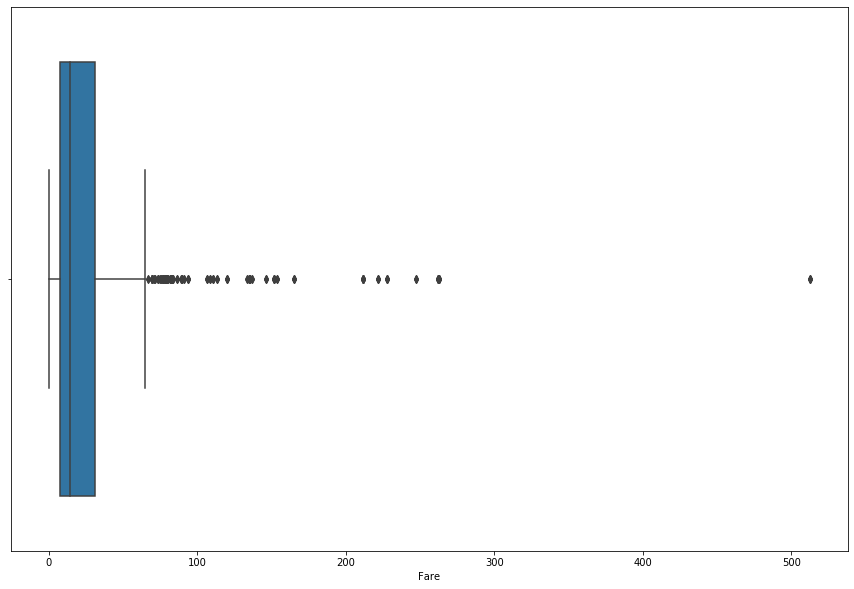

In [9]:
data_df = pd.concat([train, test])
fig,ax = plt.subplots()
fig.set_size_inches(15, 10)

sns.boxplot(data_df.Fare)

In [10]:
data_df[data_df.Fare > 300]['Fare'].count()

4

In [11]:
train = train[train.Fare < 300]

In [11]:
print('Train')
print(train.isnull().sum())
print('Test')
print(test.isnull().sum())

Train
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
Test
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## Creating new column 'Title' derived from 'Name'

In [12]:
train['Title'] = train.Name.str.split(',', n=1, expand=True)[1].str.split('.',n=1, expand=True)[0]
train['Title'] = train.Title.str.strip()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,2,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,2,Mr


In [13]:
test['Title'] = test.Name.str.split(',', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0]
test['Title'] = test.Title.str.strip()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,2,Mrs
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,1,Mr
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,2,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,2,Mrs


## Group Titles ('Mr', 'Miss', 'Mrs', 'Master', 'Other')

In [14]:
train.loc[train.Title == 'Ms', 'Title'] = 'Miss'
test.loc[test.Title == 'Ms', 'Title'] = 'Miss'

train.loc[~train.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'
test.loc[~test.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'

## Encode grouped Titles

In [15]:
title_encoder = LabelEncoder()
title_encoder.fit(['Mr', 'Miss', 'Mrs', 'Master', 'Other'])

train['Title'] = title_encoder.transform(train['Title'])
test['Title'] = title_encoder.transform(test['Title'])

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,2,2


## Unite train and test data to predict missing 'Age'-s

In [16]:
df = pd.concat([train, test])
df.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Title            0
dtype: int64

## Remove unnecessary columns for predicting missing 'Age' values

In [17]:
df = df.drop(['Name', 'PassengerId', 'Survived', 'Ticket', 'Title'], axis=1)

In [18]:
df.head()

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,0,2,7.2500,0,3,1,1
1,38.0,1,0,71.2833,0,1,0,1
2,26.0,0,2,7.9250,0,3,0,0
3,35.0,1,2,53.1000,0,1,0,1
4,35.0,0,2,8.0500,0,3,1,0


## Check out correlation matrix as heatmap

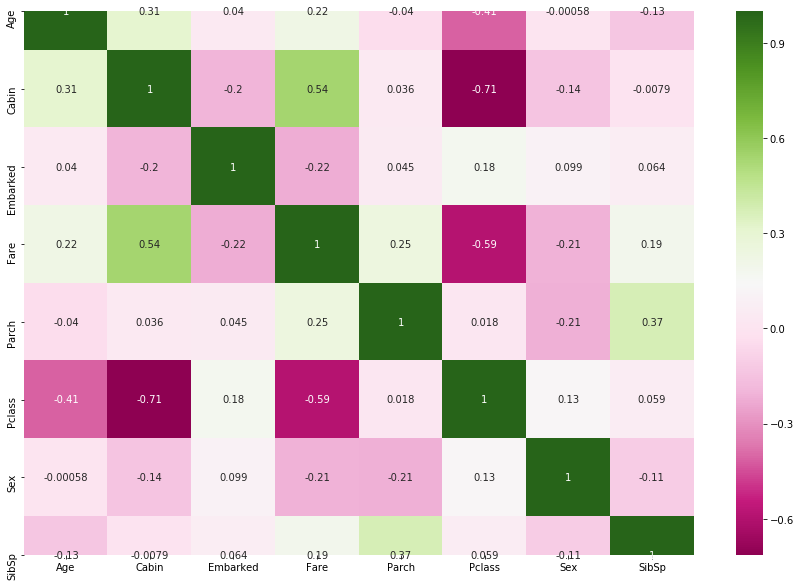

In [19]:
show_correlation(df)

In [20]:
#let's see top correlated features with 'Age' features
df.corr().Age.abs().sort_values(ascending=False)

Age         1.000000
Pclass      0.408915
Cabin       0.311124
Fare        0.222854
SibSp       0.133622
Embarked    0.040015
Parch       0.039668
Sex         0.000576
Name: Age, dtype: float64

In [21]:
#remove 'Cabin' because it is high correlated with 'Pclass' feature
df = df.drop(['Cabin'], axis=1)
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)


In [22]:
#remove 'Embarked' feature
df = df.drop(['Embarked'], axis=1)

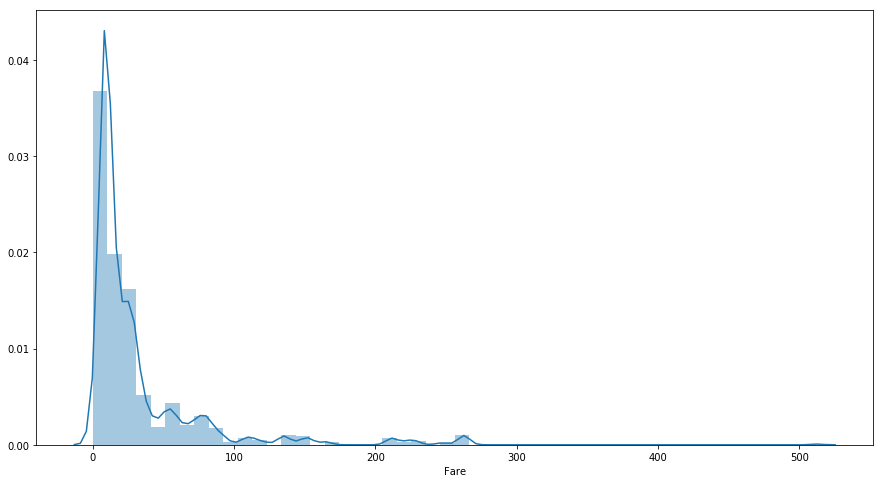

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.distplot(df['Fare'])

## Prepare predictors and targets

In [24]:
df.head()

,Age,Fare,Parch,Pclass,Sex,SibSp
0,22.0,7.2500,0,3,1,1
1,38.0,71.2833,0,1,0,1
2,26.0,7.9250,0,3,0,0
3,35.0,53.1000,0,1,0,1
4,35.0,8.0500,0,3,1,0


In [25]:
predictors = df[df.Age > 0].drop(['Age'], axis=1)
targets = df[df.Age > 0]['Age']

predictors.head()

,Fare,Parch,Pclass,Sex,SibSp
0,7.2500,0,3,1,1
1,71.2833,0,1,0,1
2,7.9250,0,3,0,0
3,53.1000,0,1,0,1
4,8.0500,0,3,1,0


In [26]:
scaler = StandardScaler()
predictors = scaler.fit_transform(predictors)

In [27]:
#split data into train and test
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)


## Predict ages using Multi Layer Perceptron

In [28]:
mlp = MLPRegressor(hidden_layer_sizes=(143, ))
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)
mean_squared_error(y_pred, y_test), mean_squared_error(mlp.predict(x_train), y_train), mlp

(150.7666447117616,
 143.63597939467311,
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(143,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))

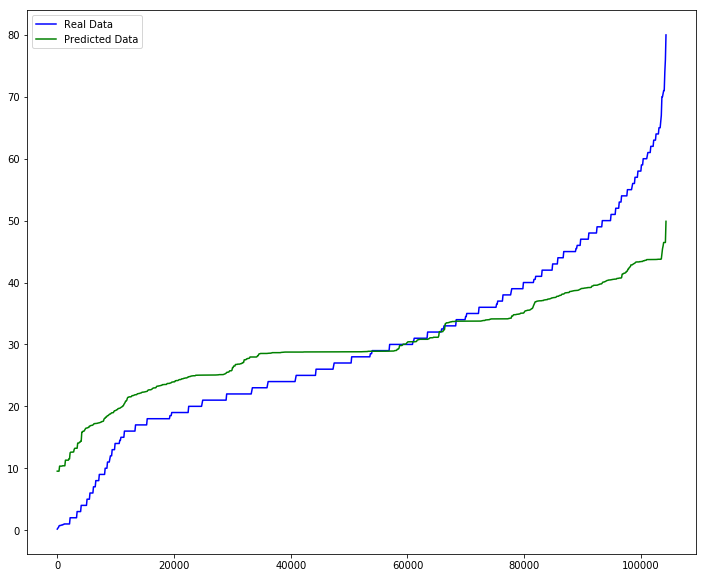

In [29]:
real_data = np.sort(np.concatenate((y_train, y_test)))
predicted_data = np.sort(np.concatenate((mlp.predict(x_train), mlp.predict(x_test))))

fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), real_data, color='b', label='Real Data')
plt.plot(np.linspace(start=0, stop=len(real_data)*100, num=len(real_data)), predicted_data, color='g', label='Predicted Data')

plt.legend()

In [30]:

train.loc[train.Age < 0, 'Age'] = mlp.predict(scaler.transform(train[train['Age'] < 0][['Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']]))
test.loc[test.Age < 0, 'Age'] = mlp.predict(scaler.transform(test[test['Age'] < 0][['Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']]))

## Show age distribution

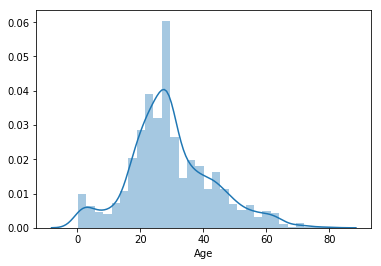

In [31]:
sns.distplot(pd.concat([train, test])['Age'])


In [32]:
pd.concat([train, test]).head()


,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,2,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,2
1,38.0,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,3
2,26.0,2,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,1
3,35.0,2,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,3
4,35.0,2,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,2


In [33]:
#remove unnecessary features: 'Name', 'Ticket'
train = train.drop(['Name', 'Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,1,22.0,1,0,7.2500,2,2
1,2,1,1,0,38.0,1,0,71.2833,0,3
2,3,1,3,0,26.0,0,0,7.9250,2,1
3,4,1,1,0,35.0,1,0,53.1000,2,3
4,5,0,3,1,35.0,0,0,8.0500,2,2


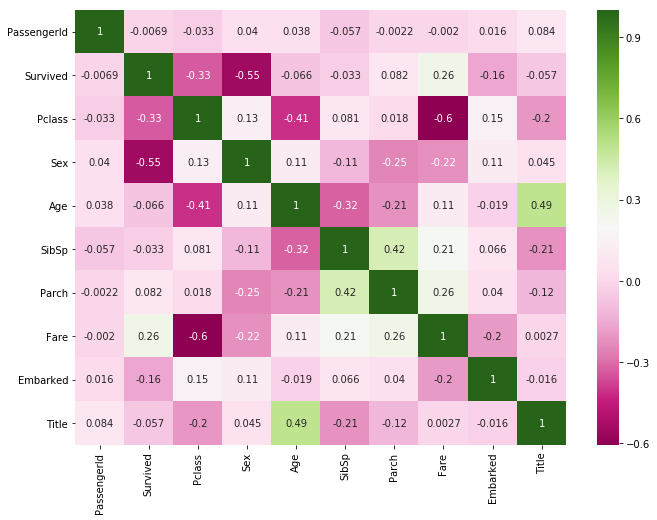

In [34]:
show_correlation(train, (11, 8))

## Prepare predictors and targets for final prediction

In [35]:
scaler = StandardScaler()
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
predictors = scaler.fit_transform(predictors)
targets = train[['Survived']]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)


## Try different classifiers

In [37]:
classifiers = {
    'KNN': KNeighborsClassifier(3),
    'SVC Linear': SVC(kernel="linear", C=0.025),
    'SVC': SVC(gamma=2, C=1),
    'Gaussian': GaussianProcessClassifier(1.0 * RBF(1.0)),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RandomForest': RandomForestClassifier(),
    'MLP': MLPClassifier(alpha=1, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis()
}

In [38]:
for name, classifier in classifiers.items():
    classifier.fit(scaler.transform(x_train), y_train)
    
    y_pred = classifier.predict(scaler.transform(x_test))
    
    score = accuracy_score(y_test, y_pred)
    print('{}: {}'.format(name, score))

KNN: 0.7704081632653061
SVC Linear: 0.7602040816326531
SVC: 0.7755102040816326
Gaussian: 0.7908163265306123
DecisionTree: 0.7908163265306123
RandomForest: 0.7653061224489796
MLP: 0.8010204081632653
AdaBoost: 0.8010204081632653
GaussianNB: 0.7551020408163265
QuadraticDiscriminantAnalysis: 0.7857142857142857


## Choose Gaussian classifier for final prediction

In [39]:
model = classifiers['MLP']


In [40]:
test.drop(['PassengerId'], axis=1).head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,1,34.5,0,0,7.8292,1,2
1,3,0,47.0,1,0,7.0000,2,3
2,2,1,62.0,0,0,9.6875,1,2
3,3,1,27.0,0,0,8.6625,2,2
4,3,0,22.0,1,1,12.2875,2,3


In [41]:
ids = test['PassengerId']
predictions = model.predict(scaler.transform(test.drop(['PassengerId'], axis=1)))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)